In [1]:
import os
import math
import numpy as np
import pandas as pd
import pywt
import matplotlib.pyplot as plt
from scipy.signal import argrelextrema, find_peaks
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)
import cv2
import glob
import scipy.stats as stats

In [2]:
%run Ipynb_importer.py

import Data_extension
import Wavelet_energy_cal
import Wavelet_local_maxima
import local_maxima_points_plot_v1
import local_maxima_points_plot_v2
import WT_Denoise

importing Jupyter notebook from Data_extension.ipynb
importing Jupyter notebook from Wavelet_energy_cal.ipynb
importing Jupyter notebook from Wavelet_local_maxima.ipynb
importing Jupyter notebook from local_maxima_points_plot_v1.ipynb
importing Jupyter notebook from local_maxima_points_plot_v2.ipynb
importing Jupyter notebook from WT_Denoise.ipynb


In [3]:
import random

import time

In [4]:
def wavelet_detection_scale_sensitivity_analysis(all_state_change_point_record, all_synthetic_trj_in, min_speed, max_speed, do_denoise):
    
    def add_energy(add_energy_to_LMP, WE):
        ene = []
        for index, row in add_energy_to_LMP.iterrows():
            if row.scale_id == 1:
                ene.append(0)
            else:
                ene.append(WE[int(row.scale_id)-2][int(round(row.time_index,1)*10)])
        return ene
    
    # add a new col 'index'
    # inplace: bool, default False
    # If True, modifies the DataFrame in place (do not create a new object).
    all_state_change_point_record_in = all_state_change_point_record.reset_index()
    
    # make a Copy for the syn data.  tips: for the .copy() deep=True is the default which means we dont need to write here. LOL.
    scale_sensitivity_analysis_results = all_state_change_point_record_in.copy(deep=True)
    
    de_scale_sensitivity_analysis_results = all_state_change_point_record_in.copy(deep=True)
    
    # set the scale range, usually do not need to be too big probab less than 50?
    scale_list = range(2, 128)
    
    # initialize results columns and set all of them to 0
    # i belongs [0, 125]
    for i in range(len(scale_list)):
        current_scale_name = 'scale_' + str(scale_list[i]) + '_time'
        current_mae_name = 'scale_' + str(scale_list[i]) + '_mae'
        scale_sensitivity_analysis_results.loc[:, current_scale_name] = 0
        scale_sensitivity_analysis_results.loc[:, current_mae_name] = 0
    
    #for i in range(0,1):
    for i in range(0, len(all_state_change_point_record_in.loc[:, 'veh_id'])):

        # get id
        current_veh_id = all_state_change_point_record_in.at[i, 'veh_id']
        print_content = 'Now in vehicle: ' + str(current_veh_id)
        print(print_content)

        # get data
        current_change_point_record = all_state_change_point_record_in.loc[i, :]
        current_veh_trj = all_synthetic_trj_in.loc[all_synthetic_trj_in['veh_id'] == current_veh_id, :]
        current_veh_speed = list(current_veh_trj.loc[:, 'speed'])
        
        if do_denoise == True:
            ext_cvs = Data_extension.Data_extension(current_veh_speed, 1000)

            np_ext_cvs = np.array(ext_cvs)
            de_np_ext_cvs = WT_Denoise.wavefilter(np_ext_cvs)
            de_ext_cvs = de_np_ext_cvs.tolist()
            de_cvs = de_ext_cvs[1000:1200]
        
        max_scale = scale_list[-1]+1
        
        # here is the change we make, we change the function below.
        # now is return the local_maxima_points
        current_local_maxima_points = Wavelet_local_maxima.wavelet_local_maxima(current_veh_speed, max_scale)
        
        de_clmp = Wavelet_local_maxima.wavelet_local_maxima(de_cvs, max_scale)

        # change the timestamp into real time_index
        current_local_maxima_points_01 = current_local_maxima_points.copy()
        current_local_maxima_points_01.time_index = current_local_maxima_points.time_index * 0.1
        
        de_clmp_01 = de_clmp.copy()
        de_clmp_01.time_index = de_clmp.time_index * 0.1

        # add Corresponding average energy to the local_maxima_points dataframe
        # because for some scale ,there is more than one point. 
        # we want to choose the one with max energy
        add_energy_to_LMP = current_local_maxima_points_01.copy()
        
        de_add_energy_to_LMP = de_clmp_01.copy()
        
        WE, coeffs = Wavelet_energy_cal.wavelet_energy_cal(current_veh_speed, max_scale)
        
        de_WE, de_coeffs = Wavelet_energy_cal.wavelet_energy_cal(de_cvs, max_scale)
        
        ene = add_energy(add_energy_to_LMP, WE)
        add_energy_to_LMP['Corresponding_energy'] = ene
        
        de_ene = add_energy(de_add_energy_to_LMP, de_WE)
        de_add_energy_to_LMP['Corresponding_energy'] = de_ene
        
        final_local_maxima_points = pd.DataFrame()
        grouped = add_energy_to_LMP.groupby(['scale_id'])
        for name,group in grouped:
            current_scale_name = 'scale_' + str(int(name)) + '_time'
            current_mae_name = 'scale_' + str(int(name)) + '_mae'
            if name > 1.0:
                result = group[group.Corresponding_energy == max(group.Corresponding_energy)]
                final_local_maxima_points = final_local_maxima_points.append(result)
                
                scale_sensitivity_analysis_results.loc[i, current_scale_name] = np.mean(result.time_index.values)
                scale_sensitivity_analysis_results.loc[i, current_mae_name] = abs(np.mean(result.time_index.values) - scale_sensitivity_analysis_results.loc[i, 'mid_change_point_time'])
        
        de_final_local_maxima_points = pd.DataFrame()
        grouped = de_add_energy_to_LMP.groupby(['scale_id'])
        for name,group in grouped:
            current_scale_name = 'scale_' + str(int(name)) + '_time'
            current_mae_name = 'scale_' + str(int(name)) + '_mae'
            if name > 1.0:
                result = group[group.Corresponding_energy == max(group.Corresponding_energy)]
                de_final_local_maxima_points = de_final_local_maxima_points.append(result)
                
                de_scale_sensitivity_analysis_results.loc[i, current_scale_name] = np.mean(result.time_index.values)
                de_scale_sensitivity_analysis_results.loc[i, current_mae_name] = abs(np.mean(result.time_index.values) - scale_sensitivity_analysis_results.loc[i, 'mid_change_point_time'])
        
        local_maxima_points_plot_v2.local_maxima_points_plot_v2(current_veh_trj, final_local_maxima_points, de_final_local_maxima_points, current_change_point_record, min_speed, max_speed, current_veh_speed, do_denoise, de_cvs)
        
    de_scale_sensitivity_analysis_results.to_csv('./data_save/de_scale_sensitivity_analysis_results.csv')
    scale_sensitivity_analysis_results.to_csv('./data_save/scale_sensitivity_analysis_results.csv')
    
    return current_veh_speed, de_cvs

In [5]:
create_new_noise_data = 0
save_new_noise_data = 0
load_data = 1
scale_sensitivity_plot = 1

# create new noise data

In [6]:
if create_new_noise_data == 1:
    all_state_change_point_record = pd.read_csv('./data_save/all_state_change_point_record.csv', header=0)
    all_synthetic_trj = pd.read_csv('./data_save/all_synthetic_trj.csv', header=0)

    # here we add noise to each speed record
    mu = 0
    # try 0.1, 0.2, 0.4 later
    sigma = 0
    do_denoise = 0

    all_speed_array = all_synthetic_trj.speed.values

    for i in range(len(all_speed_array)):
        all_speed_array[i] += random.gauss(mu,sigma)

    new_all_synthetic_trj = all_synthetic_trj.copy()
    new_all_synthetic_trj['speed'] = all_speed_array
    
    max_speed = max(new_all_synthetic_trj.speed)
    min_speed = min(new_all_synthetic_trj.speed)

    start_time = time.time()

    do_denoise = True
    
    wavelet_detection_scale_sensitivity_analysis(all_state_change_point_record, new_all_synthetic_trj, min_speed, max_speed, do_denoise)

    print ("seconds", time.time() - start_time)

In [7]:
if save_new_noise_data == 1:
    new_all_synthetic_trj.to_csv('./data_save/all_synthetic_trj_000_noise.csv')

# load data

Now in vehicle: 0
Now in vehicle: 1
Now in vehicle: 2


KeyboardInterrupt: 

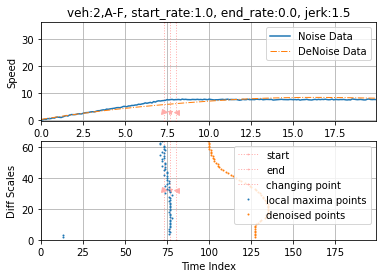

In [8]:
if load_data == 1:
    all_state_change_point_record = pd.read_csv('./data_save/all_state_change_point_record.csv', header=0)
    new_all_synthetic_trj = pd.read_csv('./data_save/all_synthetic_trj_010_noise.csv', header=0)
    
    max_speed = max(new_all_synthetic_trj.speed)
    min_speed = min(new_all_synthetic_trj.speed)
    
    start_time = time.time()

    do_denoise = True
    
    #current_veh_speed, de_cvs
    ext_cvs = wavelet_detection_scale_sensitivity_analysis(all_state_change_point_record, new_all_synthetic_trj, min_speed, max_speed, do_denoise)

    print ("seconds", time.time() - start_time)

# scale_sensitivity_analysis_results_plot

In [9]:
def scale_sensitivity_analysis_results_plot():
    scale_sensitivity_analysis_results = pd.read_csv('data_save/scale_sensitivity_analysis_results.csv', header=0)
    de_scale_sensitivity_analysis_results = pd.read_csv('data_save/de_scale_sensitivity_analysis_results.csv', header=0)
    
    scale_list = list(range(2, 128))
    mae_list = list(range(128 - 2))
    de_mae_list = list(range(128 - 2))

    for i in range(len(scale_list)):
        current_mae_name = 'scale_' + str(scale_list[i]) + '_mae'
        mae_list[i] = scale_sensitivity_analysis_results.loc[:, current_mae_name].mean()
        
    for i in range(len(scale_list)):
        current_mae_name = 'scale_' + str(scale_list[i]) + '_mae'
        de_mae_list[i] = de_scale_sensitivity_analysis_results.loc[:, current_mae_name].mean()
        
    plt.figure()
    plt.plot(scale_list, mae_list, '-^', markersize=1, linewidth=1, label='Noise Data')
    plt.plot(scale_list, de_mae_list, '-^', markersize=1, linewidth=1, label='DeNoise Data')
    plt.title('Wavelet MaxModule Scale Sensitivity Analysis')
    plt.ylabel('Mean Absolute Error (s)')
    plt.xlabel('Scale')
    plt.xlim(xmin=0)
    plt.ylim(ymin=0)
    # plt.grid(linestyle='dotted')
    plt.legend()
    fig1_save_title = 'figure_save/' + 'Wavelet Scale Sensitivity Analysis.png'
    plt.savefig(fig1_save_title, dpi=600)
    plt.close('all')

In [10]:
if scale_sensitivity_plot == 1:
    scale_sensitivity_analysis_results_plot()

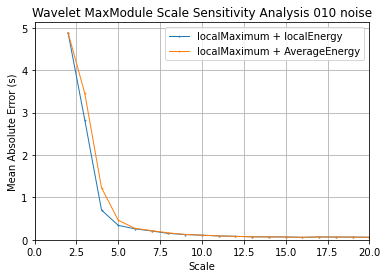

In [31]:
one = pd.read_csv('data_save/scale_sensitivity_analysis_results.csv', header=0)
scale_list = list(range(2, 128))
mae_list = list(range(128 - 2))
for i in range(len(scale_list)):
    current_mae_name = 'scale_' + str(scale_list[i]) + '_mae'
    mae_list[i] = one.loc[:, current_mae_name].mean()
plt.plot(scale_list, mae_list, '-^', markersize=1, linewidth=1, label='localMaximum + localEnergy')
plt.title('Wavelet MaxModule Scale Sensitivity Analysis 010 noise')
plt.ylabel('Mean Absolute Error (s)')
plt.xlabel('Scale')
plt.xlim([0,20])
plt.ylim(ymin=0)

two = pd.read_csv('./result_with_010_noise_extend_1000/data_save/scale_sensitivity_analysis_results.csv', header=0)
scale_list = list(range(2, 128))
mae_list = list(range(128 - 2))
for i in range(len(scale_list)):
    current_mae_name = 'scale_' + str(scale_list[i]) + '_mae'
    mae_list[i] = two.loc[:, current_mae_name].mean()
plt.plot(scale_list, mae_list, '-^', markersize=1, linewidth=1, label='localMaximum + AverageEnergy')
plt.ylabel('Mean Absolute Error (s)')
plt.xlabel('Scale')
plt.grid()

plt.legend()
plt.show()

In [47]:
ext_cvs = Data_extension.Data_extension(cvs, 1000)

np_cvs = np.array(cvs)
de_np_cvs = WT_Denoise.wavefilter(np_cvs)
de_cvs = de_np_cvs.tolist()

np_ext_cvs = np.array(ext_cvs)
de_np_ext_cvs = WT_Denoise.wavefilter(np_ext_cvs)
de_ext_cvs = de_np_ext_cvs.tolist()

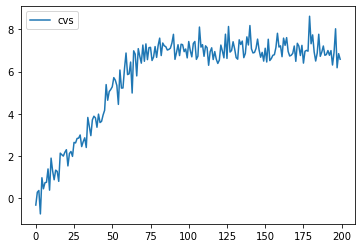

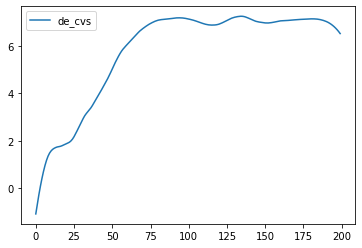

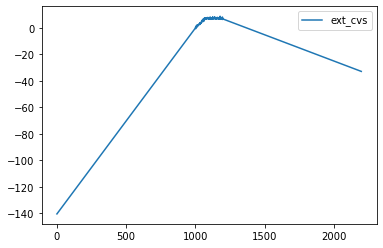

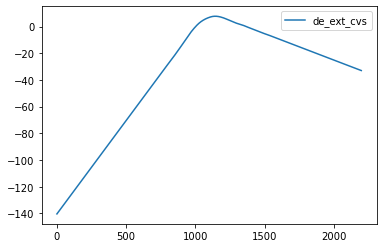

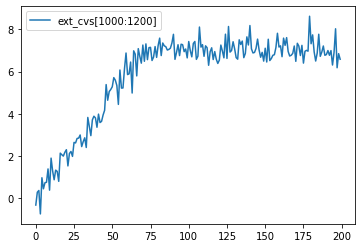

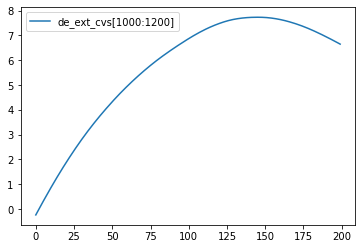

In [49]:
plt.plot(cvs, label='cvs')
plt.legend()
plt.show()
plt.plot(de_cvs, label='de_cvs')
plt.legend()
plt.show()

plt.plot(ext_cvs, label='ext_cvs')
plt.legend()
plt.show()
plt.plot(de_ext_cvs, label='de_ext_cvs')
plt.legend()
plt.show()

plt.plot(ext_cvs[1000:1200], label='ext_cvs[1000:1200]')
plt.legend()
plt.show()
plt.plot(de_ext_cvs[1000:1200], label='de_ext_cvs[1000:1200]')
plt.legend()
plt.show()